### Daylight model control

In [ ]:
# clone repository to access files
!git clone https://github.com/hella-innoLab/3PM_notebook.git

In [2]:
pip install pyradiance

Note: you may need to restart the kernel to use updated packages.


In [1]:
# import packages
import os # provides functions for interacting with the operating system
import pyradiance as pr # python implementation of RADIANCE
import subprocess as sp # running shell commands
import pandas as pd # data analysis and manipulation tool
import matplotlib.pyplot as plt # library for creating static, animated, and interactive visualizations
import numpy as np # scientific computing
from pyradiance.anci import BINPATH # path to compiled .c RADIANCE programs
from pathlib import Path
nprocs = os.cpu_count()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
'''
Calc for tilt angles of 0 to 85 degrees in 5 degree steps
-1 is added to the array to account for "no shading"
'''
slat_angles = np.arange(0,86,5)
slat_angles = np.hstack([-1, slat_angles])

cwd = os.getcwd()
files_path = os.path.join(cwd, 'files')
bsdf_path = os.path.join(files_path, 'BSDF')
matrices_path = os.path.join(files_path,'matrices')

# pre calculated matrices and files
epw_file_path = os.path.join(files_path,'weather','AUT_TR_Innsbruck.AP.111200_TMYx.epw')
bsdf_files = os.listdir(bsdf_path)
dmx_file_path = os.path.join(matrices_path,'seminarraum.dmx')

# temporary files
vmx_file_path = os.path.join(matrices_path,'tmp.vmx')
smx_file_path = os.path.join(matrices_path,'tmp.skv')
sensor_file_path = os.path.join(files_path,'pts','sensor.pts')
result_file_path_data = os.path.join(files_path,'result','result.dat')
result_file_path_ill = os.path.join(files_path,'result','result.ill')

In [3]:
'''
create a sensor_file which contains horizontal illuminance for desks
- four rows with five working spaces each
'''
#TODO: define desk heights and position in the seminar room
pts_z = 1.0
pts_x = [3.0, 4.5, 6.0, 7.5]
pts_y = [1.5, 2.5, 3.5, 4.5, 5.5]

pts = np.array([[x, y, pts_z, 0, 0, 1] for x in pts_x for y in pts_y])

np.savetxt(sensor_file_path, pts, fmt='%1.2f')

In [4]:
'''
Calculation of the view matrix
'''
nprocs = os.cpu_count()
sender_file_path = Path(f"{files_path}/scene/seminarraum_vmx_glow.rad")
scene_file_path = Path(f"{files_path}/scene/seminarraum_scene.rad")

rcopts = f"-V- -n {nprocs} -w- -I+ -ab 5 -ad 65536 -lw 1.0e-6 -faa"
cmd = f"{BINPATH}/rfluxmtx {rcopts} < {sensor_file_path} - {sender_file_path} {scene_file_path} > {vmx_file_path}"

os.system(cmd)

0

In [5]:
'''
Import epw file and extraction on needed information
'''
with open(epw_file_path, "r") as file_in:
    wea_data = file_in.readlines()

lat = float(wea_data[0].split(',')[6])
lon = -float(wea_data[0].split(',')[7])
stmer = -15

months = np.array([float(line.split(",")[1]) for line in wea_data[8:]])
days = np.array([float(line.split(",")[2]) for line in wea_data[8:]])
hours = np.array([float(line.split(",")[3]) for line in wea_data[8:]])
minutes = np.array([float(line.split(",")[4]) for line in wea_data[8:]])

direct_normal_radiation = np.array([float(line.split(",")[14]) for line in wea_data[8:]]) # W/m2
diffuse_horizontal_radiation = np.array([float(line.split(",")[15]) for line in wea_data[8:]]) # W/m2
global_horizontal_illuminance = np.array([float(line.split(",")[16]) for line in wea_data[8:]]) # lux

In [6]:
'''
Objective functions for model based control
--> goal: minimum objective function value
'''
def objective_function_ill(illum, lower_threshold, upper_threshold):
    if (illum >= lower_threshold) & (illum <= upper_threshold):
        return 0
    elif illum < lower_threshold:
        return (illum-lower_threshold)**2
    elif illum > lower_threshold:
        return (illum-upper_threshold)**2
    else:
        return np.nan

def objective_function_ill_mean(illum, lower_threshold, upper_threshold):
    return np.mean([objective_function_ill(ill, lower_threshold, upper_threshold) for ill in illum])

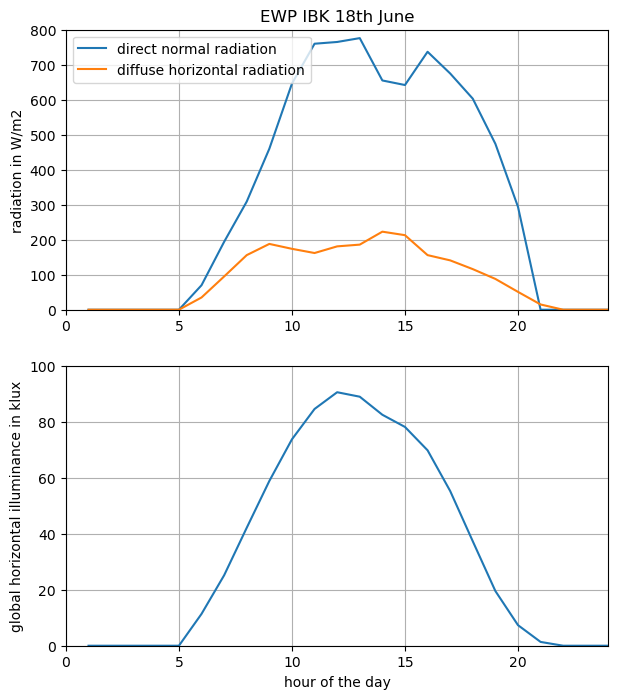

In [7]:
# select 18st of June
ind_t = np.where((months == 6) & (days == 18))[0]


# plot diffuse horizontal and global horizontal radiation
fig = plt.figure(figsize=(7,8))
ax1 = fig.add_subplot(211)
ax1.plot(hours[ind_t], direct_normal_radiation[ind_t], label = 'direct normal radiation')
ax1.plot(hours[ind_t], diffuse_horizontal_radiation[ind_t], label = 'diffuse horizontal radiation')
ax1.set(ylabel = 'radiation in W/m2', ylim = [0,800])
ax1.set(xlim = [0,24])
ax1.grid()
ax1.legend()
ax1.set_title('EWP IBK 18th June')

ax2 = fig.add_subplot(212)
ax2.plot(hours[ind_t],global_horizontal_illuminance[ind_t]/1000)
ax2.set(ylabel = 'global horizontal illuminance in klux', ylim = [0,100])
ax2.set(xlabel = 'hour of the day', xlim = [0,24])
ax2.grid()

In [8]:
'''
Calc illuminance for each day and all possible slat angles 
'''
Eh_lower_threshold = 500 # lux
Eh_upper_threshold = 725 # lux
slat_best_position = []
ill_mean, ill_std = [], []
for ti, ind_t_tmp in enumerate(ind_t):
    diffuse_horizontal_radiation_tmp = diffuse_horizontal_radiation[ind_t_tmp]
    direct_normal_radiation_tmp = direct_normal_radiation[ind_t_tmp]

    # if no outside radiation is available, no shading is needed
    if direct_normal_radiation_tmp == 0:
        slat_best_position.append(-1)
        ill_mean.append(np.full(slat_angles.size, np.nan))
        ill_std.append(np.full(slat_angles.size, np.nan))
        continue

    month_tmp = months[ind_t_tmp]
    day_tmp = days[ind_t_tmp]
    hour_tmp = hours[ind_t_tmp]
    minute_tmp = minutes[ind_t_tmp]
    
    # create sky vector
    cmd = ["gendaylit"]
    cmd.extend([str(month_tmp),str(day_tmp),str(hour_tmp + minute_tmp / 60),
        "-a", str(lat),
        "-o", str(lon),
        "-m", str(stmer),
    ])
    cmd.extend(["-W", str(direct_normal_radiation_tmp), str(diffuse_horizontal_radiation_tmp)])
    gendaylit_res = sp.run(cmd, stderr=sp.PIPE, stdout=sp.PIPE, check=True).stdout

    cmd = ["genskyvec"]
    cmd.extend(["-m", str(1)])
    
    genskyvec = sp.run(cmd, check=True, input=gendaylit_res, stdout=sp.PIPE).stdout

    with open(smx_file_path,'bw') as f:
        f.write(genskyvec)

    # calc illuminance for each slat angle
    ill = []
    for si, slat_angle_tmp in enumerate(slat_angles):
        bsdf_file_tmp = [file for file in bsdf_files if f'_{slat_angle_tmp}.' in file][0]
        bsdf_file_path_tmp = os.path.join(bsdf_path,bsdf_file_tmp)
    
        cmd = f"{BINPATH}/dctimestep {vmx_file_path} {bsdf_file_path_tmp} {dmx_file_path} {smx_file_path} > {result_file_path_data}"

        os.system(cmd)

        cmd = f"{BINPATH}/rmtxop -fa -c 47.448 119.951 11.601 -t {result_file_path_data} > {result_file_path_ill}"

        os.system(cmd)

        with open(result_file_path_ill, "r") as file_in:
            ill_tmp = [float(v) for v in file_in.readlines()[11].split()]
        ill.append(ill_tmp)
    ill_array = np.vstack(ill)

    ill_mean.append(np.mean(ill_array, axis=1))
    ill_std.append(np.std(ill_array, axis=1))

    # find illuminance for which all values are within the thresholds
    objective_function_all = [objective_function_ill_mean(ill_tmp, Eh_lower_threshold, Eh_upper_threshold) for ill_tmp in ill]

    slat_angle_best_ind = np.where(objective_function_all == np.min(objective_function_all))[0][0]

    slat_best_position.append(slat_angles[slat_angle_best_ind])

slat_angle_best_ind = [np.where(slat_angles == slat_best_position_tmp)[0][0] for slat_best_position_tmp in slat_best_position]

In [24]:
'''
Add a second control algorithm which controls the slat tilt based in outside illuminance values
'''
illum_lower_th = 1000
illum_upper_th = 60000
slat_best_position_illum = []
for ti, ind_t_tmp in enumerate(ind_t):
    outside_illum = global_horizontal_illuminance[ind_t_tmp]

    if outside_illum<illum_lower_th:
        slat_best_position_illum.append(-1)
    elif (outside_illum>=illum_lower_th) and (outside_illum<=illum_upper_th):
        slat_best_position_illum.append(40)
    else:
        slat_best_position_illum.append(45)

slat_best_position_illum_ind = [np.where(slat_angles == slat_best_position_tmp)[0][0] for slat_best_position_tmp in slat_best_position_illum]

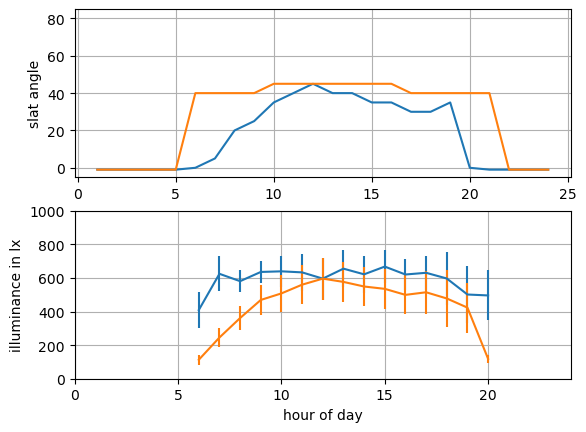

In [25]:
'''
Plot and compare results of the two control algorithms
'''

ill_mean_model_based_control = [im[i] for (im,i) in zip(ill_mean, slat_angle_best_ind)]
ill_mean_threshold_based_control = [im[i] for (im,i) in zip(ill_mean, slat_best_position_illum_ind)]
ill_std_model_based_control = [im[i] for (im,i) in zip(ill_std, slat_angle_best_ind)]
ill_std_threshold_based_control = [im[i] for (im,i) in zip(ill_std, slat_best_position_illum_ind)]

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(hours[ind_t],slat_best_position, label = 'model based control')
ax1.plot(hours[ind_t],slat_best_position_illum, label = 'threshold based control')
ax1.set(ylim = [-5, 85], ylabel = 'slat angle')
ax1.grid()

ax2 = fig.add_subplot(212)
ax2.errorbar(hours[ind_t],ill_mean_model_based_control, yerr = ill_std_model_based_control, label = 'model based control')
ax2.errorbar(hours[ind_t],ill_mean_threshold_based_control, yerr = ill_std_threshold_based_control, label = 'threshold based control')
ax2.set(xlim = [0,24], xlabel = 'hour of day')
ax2.set(ylim = [0, 1000], ylabel = 'illuminance in lx')
ax2.grid()


TASKS:
1. play with the thresholds and angles for the "threshold based control" --> can you find a configuration which works better than the model based control?
2. test it for another day and analyse if the adapted "threshold based control" is still applicable